In [1]:
import os  
import json

json_data = json.load(open("../cred.json")) # this or specify manually

os.environ["MLFLOW_TRACKING_USERNAME"] = json_data["MLFLOW_TRACKING_USERNAME"]
os.environ["MLFLOW_TRACKING_PASSWORD"] = json_data["MLFLOW_TRACKING_PASSWORD"]
os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = json_data["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"]
os.environ["AWS_DEFAULT_REGION"] = json_data["AWS_DEFAULT_REGION"]
os.environ["AWS_REGION"] = json_data["AWS_REGION"]
os.environ["AWS_ACCESS_KEY_ID"] = json_data["AWS_ACCESS_KEY_ID"]
os.environ["AWS_SECRET_ACCESS_KEY"] = json_data["AWS_SECRET_ACCESS_KEY"]
os.environ["MLFLOW_S3_ENDPOINT_URL"] = json_data["MLFLOW_S3_ENDPOINT_URL"]
os.environ["MLFLOW_TRACKING_URI"] = json_data["MLFLOW_TRACKING_URI"]


from mlflow import MlflowClient

from mlflow.server import get_app_client
import mlflow.pytorch
import mlflow.keras
import mlflow
from mlflow.models import infer_signature

import matplotlib.pyplot as plt

import keras
import torch

import numpy as np
import pandas as pd

mlflow.set_experiment("my-experiment") # change the name of the experiment to your liking


# data x is an arrau of 10x10 images of random numbers
data_X = []
for i in range(100):
    data_X.append(np.random.rand(10,10))



data_y = np.random.rand(100,4)


2024-04-30 14:34:11.474560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 14:34:12.037111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
### GENERIC MODEL EXAMPLE

from image.image_model import ExampleImageModel


# basic wrapper we use to take advantage of mlflow logging
class MyModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model_name, model):
        self.model_name = model_name
        self.model = model
    
    def predict(self, context, input, **kwargs):
        return self.model.evaluate(input)
    
    def save_model(self):
        with open(f"{self.model_name}.txt", "w") as f:
            f.write("model saved")

    def load_model(self):
        with open(f"{self.model_name}.txt", "r") as f:
            return f.read()
        
    def get_model(self): # since we are using a non-lume model we define this function to return the model
        return self.model
    
    
image_to_scalar_model = ExampleImageModel()

model = MyModel("model1", image_to_scalar_model)

input_sample = {"image": data_X[0]}

with mlflow.start_run() as run:  # you can use run_name="test1" to give a name to the run otherwise it will a random name

    
    # set some tags for the experiment
    mlflow.set_tag("exp_tag1", "exp_tag_value1")
    mlflow.set_tag("exp_tag2", "exp_tag_value2")
    mlflow.set_tag("exp_tag3", "exp_tag_value3")
    
    # model.save_model() # no need to save the model since it is saved in log_model
    mlflow.log_param("model_name", model.model_name)
    mlflow.log_param("dummy_param1", "dummy_value1")
    mlflow.log_param("dummy_param2", 0.33)
    for i in range(10):        
        mlflow.log_metric("metric1", (i / 10) ** 2 , step=i)
        mlflow.log_metric("metric2", (i / 10) ** 3 , step=i)
        mlflow.log_metric("loss", (1 / (i + 0.1) + np.random.normal(0, 0.1)) , step=i)

    # lets make some pretty graphs to store

    graph = plt.figure()
    plt.plot(range(100), [(i / 10) ** 2 for i in range(100)])
    mlflow.log_figure(graph, "figures/metric1.png")

    # alternative way to log a figure
    graph = plt.figure()
    plt.plot(range(100), [(i / 10) ** 3 for i in range(100)])
    graph.savefig("metric2.png")
    mlflow.log_artifact("metric2.png", artifact_path="figures")
    
    model_info = mlflow.pyfunc.log_model(
        artifact_path="model_files",
        python_model=model,
        signature=infer_signature(input_sample, model.predict(None, input = input_sample)),
        input_example=input_sample,
        code_path=["model_definition.py"],
        extra_pip_requirements=["paho-mqtt"] # example dependancy
        # registered_model_name="generic_model", # this will automatically register the model and iterate the version
     )

    # if you wanna log the model without the wrapper
    model.save_model()
    mlflow.log_artifact(
        f"{model.model_name}.txt", artifact_path="model_files_no_mlflow"
    )
    mlflow.log_artifact(
        f"./image/pv_mapping.yaml", artifact_path="image_model"
    )

ImportError: attempted relative import with no known parent package

In [ ]:
# specifc model uris
print(model_info.model_uri)

# lets register the models if they are not already this step is necessary for deployment
client = MlflowClient()
try:
    client.create_registered_model("image_model")
    
except:
    pass

# create new model versions

# str(dict_model)
result_generic = client.create_model_version(
    name="image_model",
    source=model_info.model_uri,
    run_id=model_info.run_id,
    tags={"tests": "passed", "framework": "pyfunc"},
)

client.set_registered_model_alias("image_model", "champion", result_generic.version)

runs:/aa3b31f870f848ad94d5a7aeef8853f6/model_files


2024/04/30 09:51:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: image_model, version 26


In [ ]:
# get model ids from registered models
image_model  = mlflow.pyfunc.load_model(f"models:/image_model@champion")

# # get model info
print("Generic model")
print(image_model, type(image_model))

test_input = {"image": data_X[0]}

print(image_model.predict(test_input))

2024/04/30 09:51:33 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - paho-mqtt (current: uninstalled, required: paho-mqtt)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Generic model
mlflow.pyfunc.loaded_model:
  artifact_path: model_files
  flavor: mlflow.pyfunc.model
  run_id: aa3b31f870f848ad94d5a7aeef8853f6
 <class 'mlflow.pyfunc.PyFuncModel'>
{'y_max': 0.9492241549604836, 'y_min': 0.008328163150936319, 'y_mean': 0.47031417955636556, 'y_std': 0.27809463059151907, 'y_img': array([[6.02390060e-01, 6.93583015e-05, 6.93583015e-05, 6.93583015e-05,
        6.93583015e-05, 4.55057092e-01, 6.93583015e-05, 5.57904735e-01,
        5.82867842e-01, 6.93583015e-05],
       [6.93583015e-05, 8.42300698e-01, 6.93583015e-05, 6.93583015e-05,
        6.93583015e-05, 6.93583015e-05, 8.16664254e-01, 8.00596281e-01,
        6.93583015e-05, 6.93583015e-05],
       [6.93583015e-05, 6.93583015e-05, 6.93583015e-05, 6.93583015e-05,
        9.01026496e-01, 6.64382200e-01, 6.93583015e-05, 6.93583015e-05,
        6.93583015e-05, 7.00144466e-01],
       [6.93583015e-05, 6.93583015e-05, 6.93583015e-05, 6.93583015e-05,
        6.93583015e-05, 6.93583015e-05, 6.93583015e-05, 6.935

In [ ]:
test_input = {"image": data_X[1]}

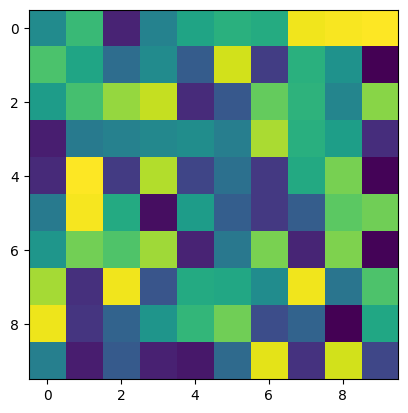

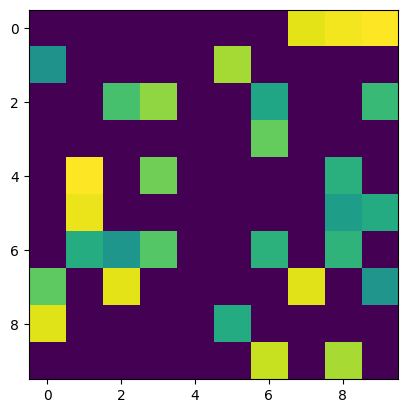

In [ ]:
from matplotlib import pyplot as plt

output = image_model.predict(test_input)

plt.imshow(test_input["image"])
plt.show()

plt.figure()

plt.imshow(output["y_img"])
plt.show()